# Прогнозирование оттока клиентов в компании по предоставлению услуг связи
Оператор связи «Ниединогоразрыва.ком»
Информация о компании
Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Цель пректа - еобходимо разработать модель, способную адекватно прогнозировать какие клиенты в ближайшее время захотят сменить оператора для предоставления им промоакций с целью предотвратить их уход с метрикой качества прогноза на тестовой выборке ROC-AUC >=0.85, срок выполнения проекта до 21.04.2023

# Предоставленные данные

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Этап 1 - План работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
contract= pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


Данные "contract_new.csv" содержат следующую информацию: \
customerID - уникальный идентификатор договора\
Begin Date - дата начала договора\
End Date - дата окончания договора (если договор действителен, то в графе стоит значение "No")\
Type - тип заключенного договора (на месяц, на 1 год и т.д.)\
Paper less Billing - содержит информацию о согласии клиента на электронное сопровождение договора\
Payment Method	- способ оплаты\
Monthly Charges	- среднемесячные платежи\
Total Charges - Общая сумма оплаты

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В данных нет пропусков\
у некоторых столбцов необходимо изменить тип данных:\
TotalCharges на float64\
BeginDate на date\
EndDate - целевой признак для обучения модели, вероятно стоит добавить дополнительный столбец где значение 0, договор завершен, 1 договор действителен. 

In [5]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [6]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

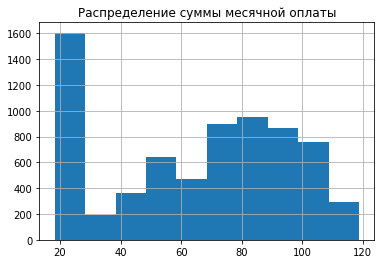

In [7]:
contract['MonthlyCharges'].hist()
plt.title('Распределение суммы месячной оплаты');

Суммы месячного платежа распределены следующим образом:\
максимальное количество людей оплачивают ежемесячно суммы до 30 долларов\
максимальная сумма оплаты 118 долларов\
значительное количество людей имеют большие ежемесячные платежи от 70 до 110 долларов\
стандартное и среднее сильно отличаются

In [8]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors ='coerce')

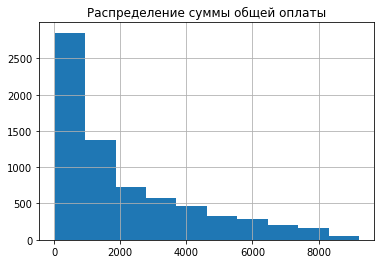

In [9]:
contract['TotalCharges'].hist()
plt.title('Распределение суммы общей оплаты');

In [10]:
contract['TotalCharges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


При оценке значений с общей суммой оплаты было выявлено, что по большой части договоров внесено около 2000 долларов. 

In [12]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [15]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

при анализе данных "personal_new.csv" получена информация о гендерной принадлежности, является ли человек пенсионером(personal['SeniorCitizen'] со значением 1), состоит ли в браке и есть ли дети\
personal['SeniorCitizen'] необходимо изменить тип данных

In [16]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


данные "internet_new.csv" содержит информацию об использовании дополнительных услуг(антивирус, облачное хранилище и тд) и типе подключения

In [18]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


данные "phone_new.csv" содержат информацию  об использовании услуг стационарной телефонной связи и использование дополнительной услуги подключение к нескольким линиям

По всем полученным данным можно сделать вывод, что большинство клиентов пользуется и услугами интернета и стационарным телефоном, но есть и те кто пользуется только или интернетом или стационарным телефоном, данный факт может усложнить обучение модели

### План работы:

1. Предобработка данных. Работа с пропусками. Определение аномальных значений. Преобразование типов данных. Поиск дубликатов. 
2. Исследовательский анализ данных. Визуализация. Изучение срезов данных. Нахождение взаимосвязей параметров. Объединение таблиц. Вывод по данным.
3. Машинное обучение. Определение гиперпараметров. Кодирование данных. Сравнение качества прогноза моделей. 
4. Проверка адекватности выбранной модели. Общий вывод. 

# Этап 2 Код решения

## Подготовка данных

Добавим некоторые влияющие и целевой признаки в датасет contract

In [20]:
contract['Target']=(contract['EndDate']=='No').astype(int)

In [21]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1


In [22]:
contract['Target'].value_counts(normalize= True )

1    0.843675
0    0.156325
Name: Target, dtype: float64

Присутствует явный дисбаланс классов: 84 % договоров действительны. 

Для определения степени влияния даты начала договора необходимо дополнить столбец EndDate (заменить NO на дату выгрузки данных) и изменить тип данных

In [23]:
contract['EndDate'] = contract['EndDate'].where(contract['EndDate'] != 'No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1


In [24]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [25]:
contract['Validity'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [26]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Validity
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153


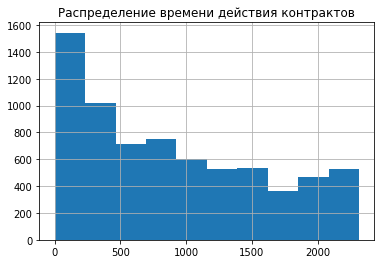

In [27]:
contract['Validity'].hist()
plt.title('Распределение времени действия контрактов');

Договоры со сроком действия менее 32 дней не показательны (среди еще не завершенных), поскольку это новые клиенты и договоры с ними были заключены в январе и еще не успели закончиться на момент выгрузки

In [28]:
(contract['BeginDate'] == '2020-01-01').sum() / contract['Validity'].count()*100

3.3082493255714893

In [29]:
((contract['Validity'] <= 31) & (contract['Target'] == 1)).sum() / contract['Validity'].count()*100

3.4644327701263666

Не показательные данные со сроком действия менее 32 дней составляют 3,5 процента. Можем их удалить после объединения в общий датасет.

В качестве дополнительного признака необходимо добавить какими именно услугами пользуется человек, поскольку это может повлиять на целевой признак. Для этого добавим столбцы равные 'Yes' в датасеты internet и phone

In [30]:
internet['internet'] = 'Yes'
phone['phone'] = 'Yes'

In [31]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes


ОБЪЕДИНЯЕМ в общий датает

In [32]:
df = contract.copy()
df = df.merge(personal, how='left', on='customerID')
df = df.merge(internet, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID') 
df = df[df['TotalCharges']>0]

In [33]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Validity,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,...,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,1036,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,...,DSL,Yes,No,Yes,Yes,No,No,Yes,NaN,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7032 non-null   int64         
 9   Validity          7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetService   5512 n

В данных образовались пропуски по причине того, что некоторые пользуются только услугами телефонной связи или только услугами интернета, Заполним пропуски на "No"

In [35]:
df = df.fillna('No')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7032 non-null   int64         
 9   Validity          7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetService   7032 n

Удалим столбцы, которые не нужны для обучения и анализа модели: customerID, BeginDate, EndDate. 

In [37]:
df = df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Target            7032 non-null   int64  
 6   Validity          7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   object 
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


Датасет подготовлен для дальнейшей работы, было выполнено: 
- добавлен целевой признак Target 
- добавлены новые признаки Validity, internet, phone
- изменены типы данных
- удалены неинформативные признаки
- удалены непоказательные данные (недавно заключенные договоры) 

Полученный датасет состоит из 7032 строк, имеет 1 целевой признак и 19 влияющих

## Исследование данных

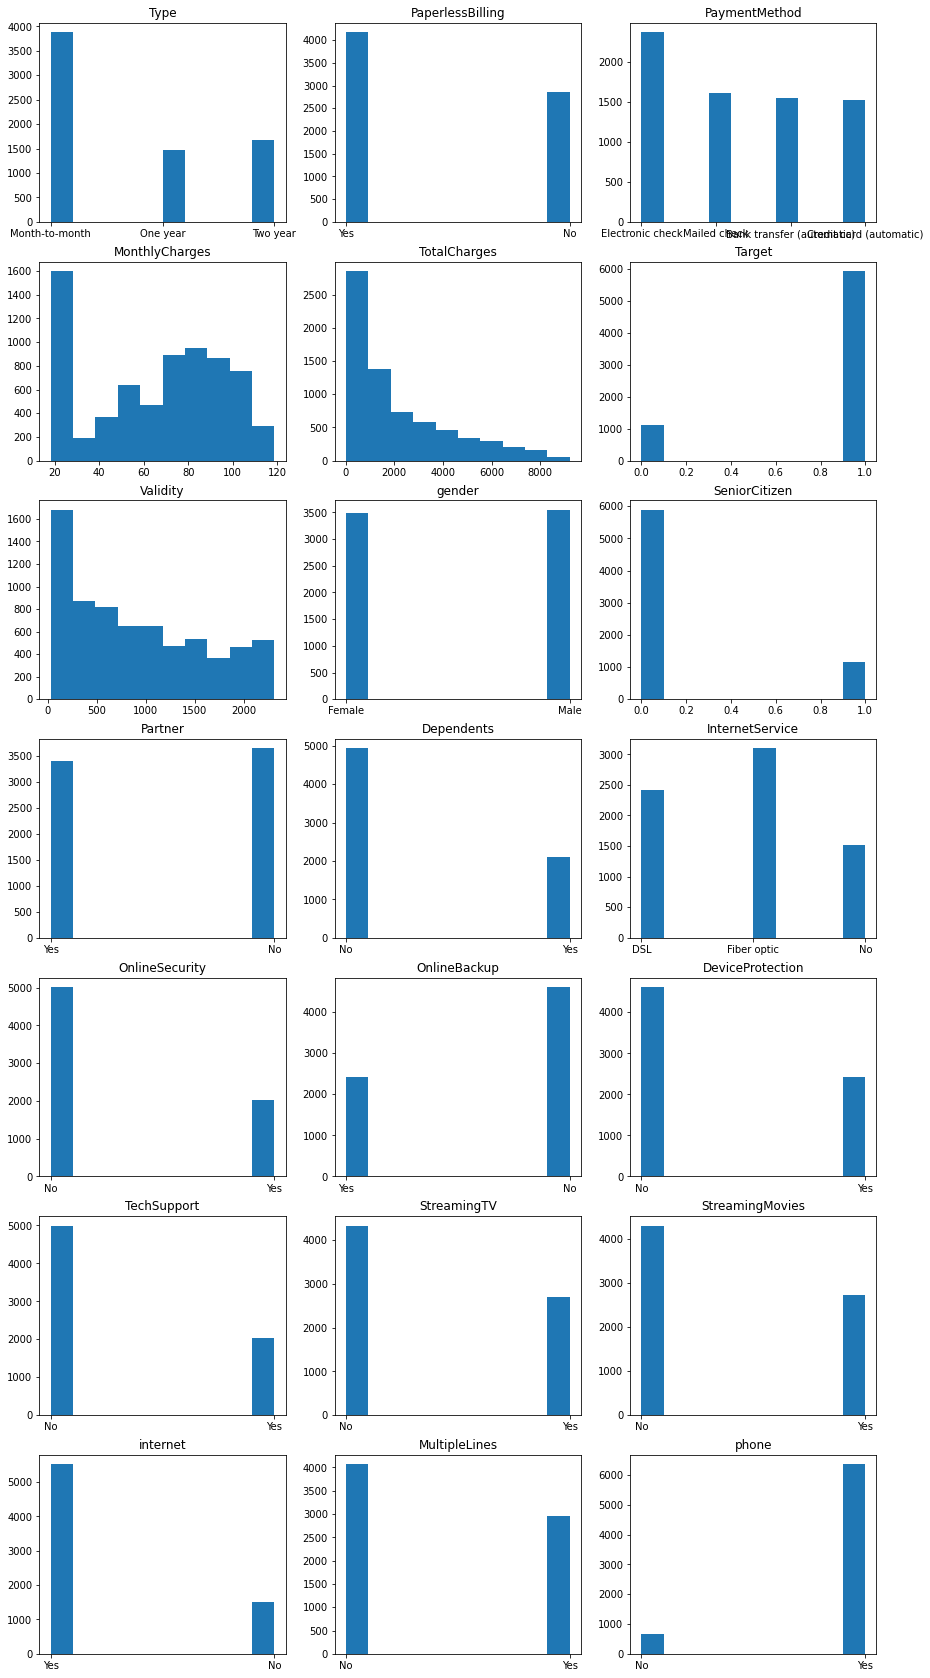

In [39]:
a = df.columns.values
i = 0
plt.figure(figsize=(15, 30))
for column in a:
    i += 1 
    plt.subplot(7, 3, i)
    plt.hist(df[column])
    plt.title(column)

По общему анализу распределения данных можно сделать следующие выводы:
- Самый частый тип договоров с месячной оплатой и электронным чеком
- максимальное количество людей оплачивают ежемесячно суммы до 30 долларов
- значительное количество людей имеют большие ежемесячные платежи от 70 до 110 долларов
- целевой признак требует балансировки
- количество мужчин и женщин в выборке приблизительно равные, как и с детьми или без
- все дополнительные услуги пользуются популярностью

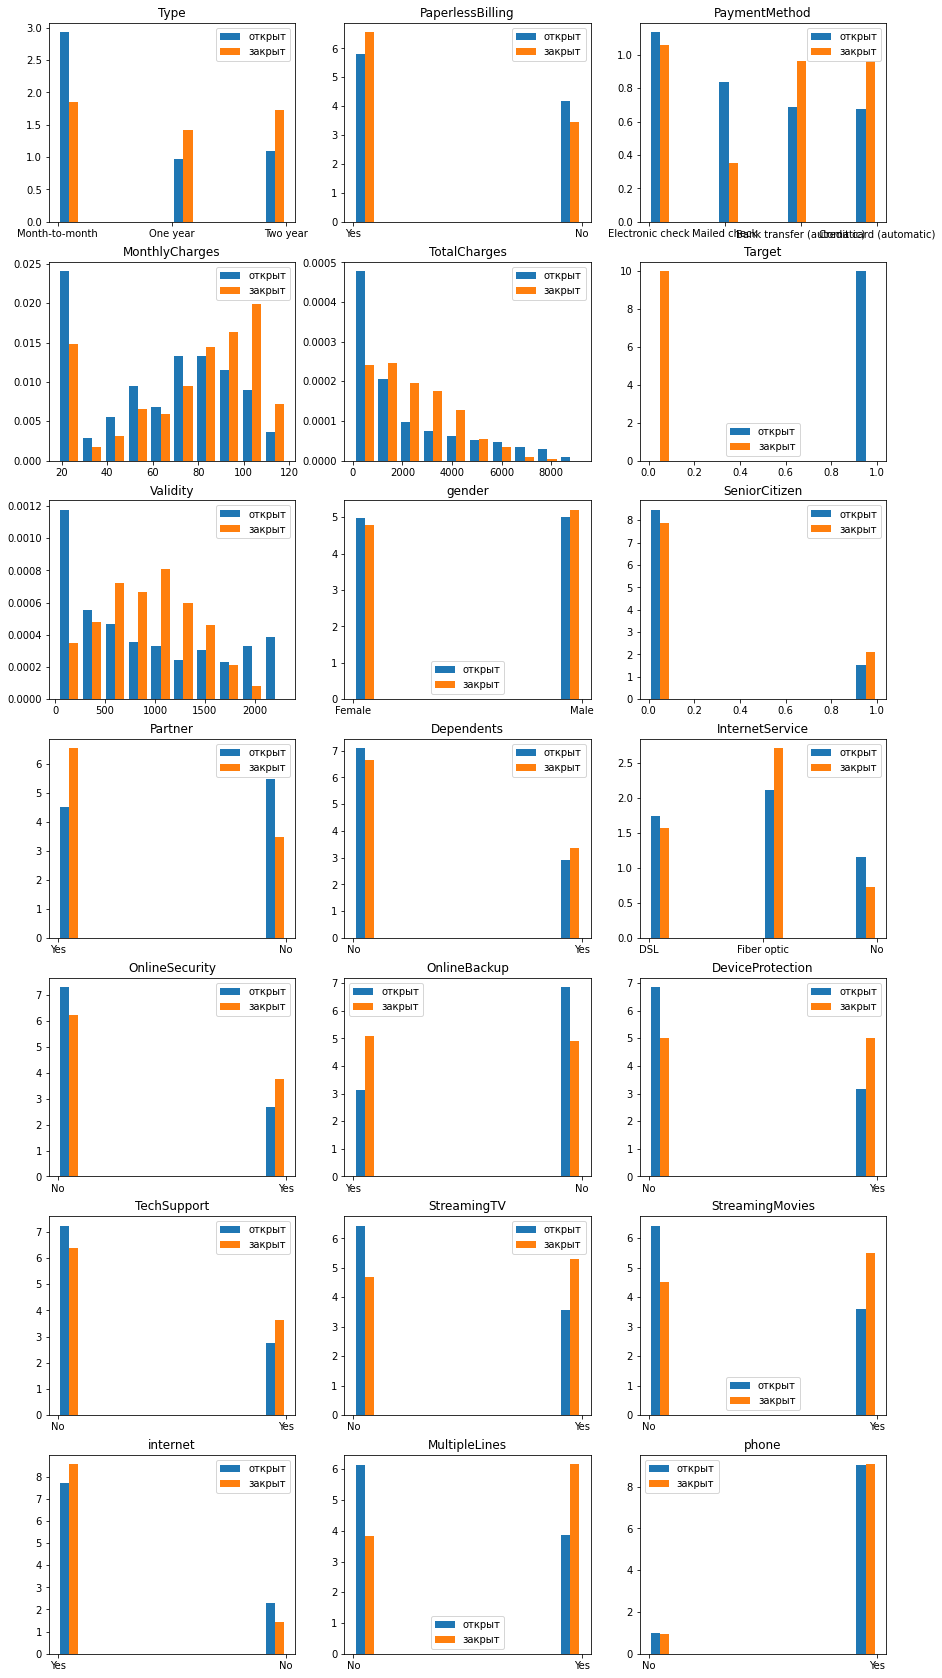

In [40]:
df1 = df[df['Target'] == 1]
df0 = df[df['Target'] == 0]
i = 0
plt.figure(figsize=(15, 30))
for column in a:
    i += 1 
    plt.subplot(7, 3, i)
    plt.hist([df1[column], df0[column]], label=['открыт', 'закрыт'], density=True)
    plt.title(column)
    plt.legend()

При сравнительном анализе признаков с делением на открытые и закрытые договоры можно сделать следующие выводы, что чаще отказываются от услуг компании те клиенты, которые:
- заключают договор с годичной оплатой (1 раз в год или в 2 года)
- имеют большие ежемесячные платежи (более 80 долларов)
- являются клиентами от 500 до 1500 дней
- женатые(странная корреляция)
- используют интернет, подключенный по технологии оптического кабеля
- пользуются дополнительными услугами (OnlineBackup, StreamingTV, StreamingMovies, MultipleLines)
- признаки не влияющие на уход клиента (gender,  SeniorCitizen, Dependents, TechSupport, phone)


In [41]:
numerical = ['Validity', 'MonthlyCharges', 'TotalCharges']

In [42]:
df[numerical].corr()

,Validity,MonthlyCharges,TotalCharges
Validity,1.000000,0.218955,0.821442
MonthlyCharges,0.218955,1.000000,0.630297
TotalCharges,0.821442,0.630297,1.000000


In [43]:
df.corr()

,MonthlyCharges,TotalCharges,Target,Validity
MonthlyCharges,1.000000,0.630297,-0.153927,0.218955
TotalCharges,0.630297,1.000000,-0.051548,0.821442
Target,-0.153927,-0.051548,1.000000,-0.015716
Validity,0.218955,0.821442,-0.015716,1.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Target            7032 non-null   int64  
 6   Validity          7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   object 
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


Значительная корреляция между Validity и TotalCharges, что понятно, чем больше дней, тем больше сумма, удалим столбец TotalCharges перед обучением модели

## Обучение моделей

### Подготовка данных к обучению 
- удалить столбец TotalCharges
- удалить не влияющие на уход клиента признаки (gender, SeniorCitizen, Dependents, TechSupport, phone)
- выделить целевой признак
- разбить на тестовую и обучающую выборку 
- применить стандартизацию к числовым признакам
- применить кодирование к категориальным признакам

In [45]:
RS = 100423

In [46]:
col_del = ['TotalCharges', 'gender', 'SeniorCitizen', 'Dependents', 'TechSupport', 'phone']

In [47]:
df = df.drop(columns=col_del)
target = df['Target']
features = df.drop(['Target'], axis=1)

In [48]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = RS, stratify=target)
print('Размер обучающей выборки', features_train.shape[0], f'{  features_train.shape[0]/features.shape[0]:.1%}')
print('Размер  валидационной выборки', features_test.shape[0], f'{  features_test.shape[0]/features.shape[0]:.1%}')

Размер обучающей выборки 5274 75.0%
Размер  валидационной выборки 1758 25.0%


In [49]:
numeric = ['Validity', 'MonthlyCharges']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])
features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_ones] + [features_zeros] * repeat)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RS)
    
    return features_upsampled, target_upsampled

In [51]:
target_train[target_train == 1].count()/target_train[target_train == 0].count()

5.38498789346247

In [52]:
#features_train, target_train = upsample(features_train, target_train, 3)

In [53]:
target_train[target_train == 1].count()/target_train[target_train == 0].count()

5.38498789346247

In [54]:
var_categorical = ['Type', 'PaperlessBilling', 'PaymentMethod', 
'Partner', 'InternetService', 'OnlineSecurity',
'OnlineBackup', 'DeviceProtection', 'StreamingTV',
'StreamingMovies', 'internet', 'MultipleLines']
encoder = OneHotEncoder(handle_unknown='error', drop='first')
train_ohe = pd.DataFrame(encoder.fit_transform(features_train[var_categorical]).toarray(),
                       columns=encoder.get_feature_names(),
                       index=features_train.index)
test_ohe = pd.DataFrame(encoder.transform(features_test[var_categorical]).toarray(),
                        columns=encoder.get_feature_names(),
                       index=features_test.index)
features_train_ohe = pd.concat([features_train, train_ohe], axis=1)
features_test_ohe = pd.concat([features_test, test_ohe], axis=1)
features_train_ohe = features_train_ohe.drop(columns = var_categorical)
features_test_ohe = features_test_ohe.drop(columns = var_categorical)

In [55]:
encoder2 = OrdinalEncoder()

In [56]:
train_OE = features_train[var_categorical]
train_OE = pd.DataFrame(encoder2.fit_transform(train_OE),
                        columns=train_OE.columns, index=train_OE.index) 
features_train_oe = features_train.copy()
for column in var_categorical:
    features_train_oe[column] = train_OE[column]


In [57]:
test_OE = features_test[var_categorical]
test_OE = pd.DataFrame(encoder2.transform(test_OE),
                        columns=test_OE.columns, index=test_OE.index) 
features_test_oe = features_test.copy()
for column in var_categorical:
    features_test_oe[column] = test_OE[column]

В ходе подготовки данных было выполнено следующее:
- Выделен целевой признак, разбили на тестовую и обучающую выборки (Размер обучающей выборки 5099 75.0% Размер  валидационной выборки 1700 25.0%)
- применили стандартизацию к числовым признакам с помощью StandardScaler
- сбалансировали классы (увеличив количесво закрытых договоров в 3 раза)


применили кодирование к категориальным признакам:
1. OneHotEncoder - получили данные features_train_ohe и features_test_ohe
2. OrdinalEncoder - получили данные features_train_oe и features_test_oe

In [58]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 2698 to 2658
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1758 non-null   object 
 1   PaperlessBilling  1758 non-null   object 
 2   PaymentMethod     1758 non-null   object 
 3   MonthlyCharges    1758 non-null   float64
 4   Validity          1758 non-null   float64
 5   Partner           1758 non-null   object 
 6   InternetService   1758 non-null   object 
 7   OnlineSecurity    1758 non-null   object 
 8   OnlineBackup      1758 non-null   object 
 9   DeviceProtection  1758 non-null   object 
 10  StreamingTV       1758 non-null   object 
 11  StreamingMovies   1758 non-null   object 
 12  internet          1758 non-null   object 
 13  MultipleLines     1758 non-null   object 
dtypes: float64(2), object(12)
memory usage: 206.0+ KB


### Обучение моделей

Для обучения протестируем и обучим следующие модели: 
1. LogisticRegression
2. RandomForestClassifier
3. CatBoostClassifier

#### LogisticRegression

In [59]:
def plot_roc_curve(target, predictions):
    print('ROC-AUC', roc_auc_score(target, predictions))
    fpr, tpr, thresholds = roc_curve(target, predictions)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.show()

In [60]:
LR = LogisticRegression(solver='liblinear', n_jobs=-1, random_state=RS, class_weight='balanced')
param_grid = {'C': [ 1, 10, 100, 1000, 10000]}
LR_cv = GridSearchCV(LR, param_grid, cv=3, scoring='roc_auc')
LR_cv.fit(features_train_ohe, target_train)
LR_BP = LR_cv.best_params_

In [61]:
roc_auc_LR = LR_cv.best_score_
roc_auc_LR

0.7583343576350748

### RandomForestClassifier

In [62]:
param_grid_RFC = {'max_depth': [5, 10],
    'n_estimators': [50, 100, 150]}

RFC = RandomForestClassifier(random_state=RS, class_weight='balanced')

RFC_cv = GridSearchCV(RFC, param_grid_RFC, cv=3, scoring='roc_auc')
RFC_cv.fit(features_train_oe, target_train)
RFC_BP = RFC_cv.best_params_

In [63]:
roc_auc_RFC = RFC_cv.best_score_
roc_auc_RFC

0.8280569353141919

### CatBoostClassifier

In [64]:
param_grid_CBC = {'n_estimators': [150, 200, 300]}

CBC = CatBoostClassifier(random_state=RS, verbose=0)

CBC_cv = GridSearchCV(CBC, param_grid_CBC, cv=3, scoring='roc_auc')
CBC_cv.fit(features_train_oe, target_train)
CBC_BP = CBC_cv.best_params_

In [65]:
roc_auc_CBC = CBC_cv.best_score_
roc_auc_CBC

0.8676179611326531

### Вывод по обучению моделей

In [66]:
summ = pd.DataFrame(
    {'параметры': [LR_BP, RFC_BP, CBC_BP],
     'ROC-AUC': [roc_auc_LR, roc_auc_RFC, roc_auc_CBC]},
    index = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'])
summ

,параметры,ROC-AUC
LogisticRegression,{'C': 1},0.758334
RandomForestClassifier,"{'max_depth': 5, 'n_estimators': 100}",0.828057
CatBoostClassifier,{'n_estimators': 300},0.867618


В ходе обучения моделей был произведен подбор гиперпараметров для моделей LogisticRegression, RandomForestClassifier, CatBoostClassifier и произведен расчет ROC-AUC. Лучшее значение на обучающей выборке у модели CatBoostClassifier с гиперпараметрами n_estimators': 300. 

### Проверка выбранной модели

ROC-AUC 0.8871207012811868
accuracy 0.8902161547212741


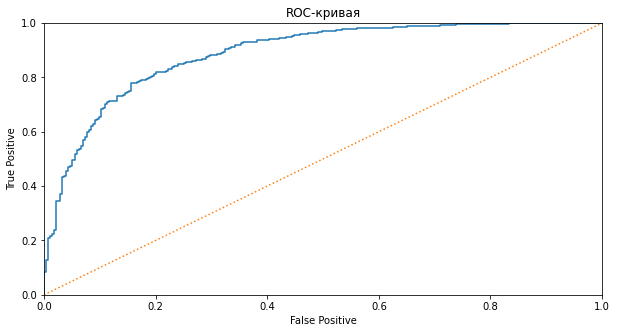

In [67]:
predictions = CBC_cv.best_estimator_.predict_proba(features_test_oe)[:, 1]
predictions2 = CBC_cv.best_estimator_.predict(features_test_oe)
print('ROC-AUC', roc_auc_score(target_test, predictions))
print('accuracy', accuracy_score(target_test, predictions2))
fpr, tpr, thresholds = roc_curve(target_test, predictions)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC-кривая')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.show()

Требуемая метрика качества на обучающей выборке получена.\
Модель CatBoostClassifier (n_estimators': 300)\
ROC-AUC 0.88\
accuracy 0.89

In [68]:
from sklearn.metrics import confusion_matrix
ind = ['предсказание ухода клиента','предсказание лояльности клиента']
col = ['фактический уход клиента','фактическая лояльность клиента']
matrix = pd.DataFrame(confusion_matrix(target_test, predictions2), index = ind, columns=col)
matrix

,фактический уход клиента,фактическая лояльность клиента
предсказание ухода клиента,107,168
предсказание лояльности клиента,25,1458


При построении матрицы ошибок было выявлено, что разработанная модель чаще будет ошибаться в предсказании, что человек планирует сменить оператора, что может уменьшить прибыль от данных клиентов, поскольку им будут предлжены более выгодные условия.\
Однако модель в более редких случаях не заметит клиента, который планирует сменить оператора, что является более весомым фактором. 

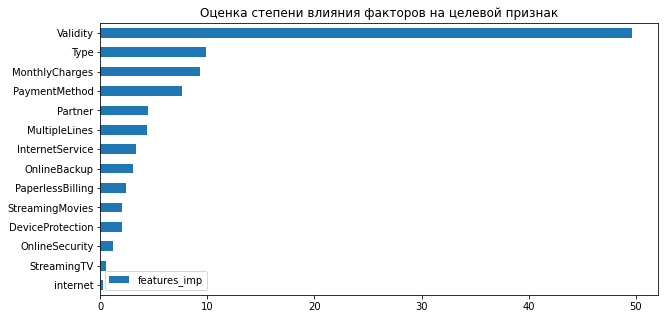

In [69]:
features_imp = pd.DataFrame(CBC_cv.best_estimator_.feature_importances_, index = features_test.columns, columns=['features_imp'])
features_imp = features_imp.sort_values(by='features_imp', ascending=True)
features_imp.plot(kind='barh', figsize=(10, 5))
plt.title('Оценка степени влияния факторов на целевой признак')
plt.show()


При оценке степени влияния на целевой признак было выявлено, что наиболее влияющим фактором является длительность договора, также в значительной степени влияют: тип договора, сумма оплаты в месяц, и способ оплаты.

## Вывод

1.	В ходе подготовки данных были произведены следующие действия: 
•	добавлен целевой признак Target\
•	добавлены новые признаки Validity, internet, phone\
•	изменены типы данных\
•	удалены неинформативные признаки\
•	удалены непоказательные данные (недавно заключенные договоры)\
Получили датасет из 6799 строк, 1 целевой признак и 19 влияющих


2.	В ходе исследования данных были сделаны следующие выводы: 

По общему анализу распределения данных:

•	Самый частый тип договоров с месячной оплатой и электронным чеком\
•	максимальное количество людей оплачивают ежемесячно суммы до 30 долларов\
•	значительное количество людей имеют большие ежемесячные платежи от 70 до 110 долларов\
•	целевой признак требует балансировки\
•	количество мужчин и женщин в выборке приблизительно равные, как и с детьми или без\
•	все дополнительные услуги пользуются популярностью

При сравнительном анализе признаков с делением на открытые и закрытые договоры чаще отказываются от услуг компании те клиенты, которые:

•	заключают договор с годичной оплатой (1 раз в год или в 2 года)\
•	имеют большие ежемесячные платежи (более 80 долларов)\
•	являются клиентами от 500 до 1500 дней\
•	женатые(странная корреляция)\
•	используют интернет, подключенный по технологии оптического кабеля\
•	пользуются дополнительными услугами (OnlineBackup, StreamingTV, StreamingMovies, MultipleLines)\
признаки не влияющие на уход клиента (gender, SeniorCitizen, Dependents, TechSupport, phone)

3.	В ходе обучения моделей было выполнено:

3.1 Подготовка данных:\
•	Выделен целевой признак, разбили на тестовую и обучающую выборки (Размер обучающей выборки 5099 75.0% Размер валидационной выборки 1700 25.0%)\
•	применили стандартизацию к числовым признакам с помощью StandardScaler\
•	сбалансировали классы (увеличив количесво закрытых договоров в 5 раз)\
кодирование к категориальным признакам: OneHotEncoder - получили данные features_train_ohe и features_test_ohe, OrdinalEncoder - получили данные features_train_oe и features_test_oe


3.2  Обучение моделей -  произведен подбор гиперпараметров методом GridSearchCV для моделей LogisticRegression, RandomForestClassifier, CatBoostClassifier и произведен расчет ROC-AUC. Лучшее значение на обучающей выборке у модели CatBoostClassifier с гиперпараметрами n_estimators': 300.


3.3 Тестирование выбранной модели: \
Требуемая метрика качества на обучающей выборке получена.\
Модель CatBoostClassifier (n_estimators': 300)\
ROC-AUC 0.89\
accuracy 0.87
    
3.4 При построении матрицы ошибок было выявлено, что разработанная модель чаще будет ошибаться в предсказании, что человек планирует сменить оператора, что может уменьшить прибыль от данных клиентов, поскольку им будут предлжены более выгодные условия.\
Однако модель в более редких случаях не заметит клиента, который планирует сменить оператора, что является более весомым фактором.

3.5 При оценке степени влияния на целевой признак было выявлено, что наиболее влияющим фактором является длительность договора, также в значительной степени влияют: тип договора, сумма оплаты в месяц, и способ оплаты.

# Этап 3 Отчет

Аннотация\
В ходе проведенного исследования была обучена модель машинного обучения, способная прогнозировать уход клиентов по заказу оператора связи «Ниединогоразрыва.ком», для предоставления клиентам, которые склонны к смене оператора, дополнительных скидок или акций. Набор данных, предоставленный заказчиком, содержал в себе общую информацию о клиентах и условиях их договора. В ходе исследования было выявлено, что некоторые данные требуют корректировки или в целом не влияют на лояльность клиента. Полученный набор данных тестировали на трех разных моделях. Лучший результат обучения получили на модели CatBoostClassifier с точностью прогноза на тестовой выборке 87 %. 

### Введение
1.1 Цель проекта - разработать модель, способную адекватно прогнозировать какие клиенты в ближайшее время захотят сменить оператора для предоставления им промоакций с целью предотвратить их уход с метрикой качества прогноза на тестовой выборке ROC-AUC >=0.85, срок выполнения проекта до 21.04.2023\
1.2 Набор данных – для анализа данных заказчиком были предоставлены следующие датасеты: \
•	contract_new.csv — информация о договоре, где:\
customerID - уникальный идентификатор договора\
Begin Date - дата начала договора\
End Date - дата окончания договора (если договор действителен, то в графе стоит значение "No")\
Type - тип заключенного договора (на месяц, на 1 год и т.д.)\
Paper less Billing - содержит информацию о согласии клиента на электронное сопровождение договора\
Payment Method - способ оплаты\
Monthly Charges - среднемесячные платежи\
Total Charges - Общая сумма оплаты

•	personal_new.csv — персональные данные клиента - информация о гендерной принадлежности, является ли человек пенсионером(personal['SeniorCitizen'] со значением 1), состоит ли в браке и есть ли дети\
•	internet_new.csv — информация об интернет-услугах; -  информацию об использовании дополнительных услуг(антивирус, облачное хранилище и тд) и типе подключения\
•	phone_new.csv — информация об услугах телефонии - информацию об использовании услуг стационарной телефонной связи и использование дополнительной услуги подключение к нескольким линиям\
Во всех файлах столбец customerID содержит код клиента.\
Информация о договорах актуальна на 1 февраля 2020.

1.3 Признаки и предварительное исследование данных\
На основе столбца End Date был подготовлен целевой признак бинарной классификации, где 1 договор действителен, 0 – договор недействителен. В данных присутсвует дисбаланс классов: 84 % договоров действительны. 
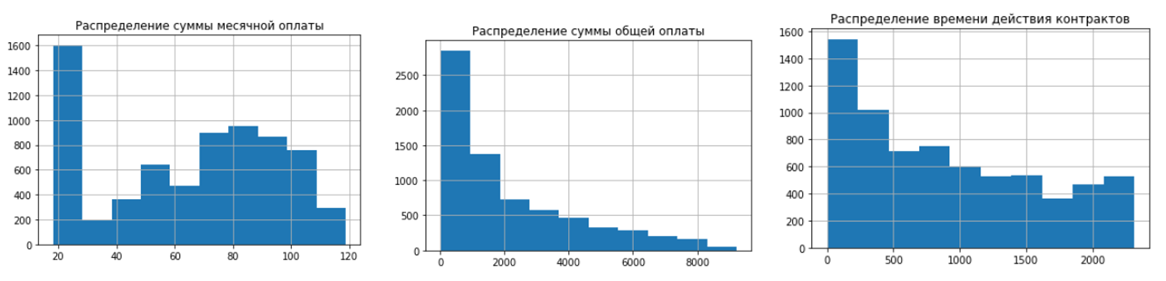
Суммы месячного платежа распределены следующим образом: максимальное количество людей оплачивают ежемесячно суммы до 30 долларов, максимальная сумма оплаты 118 долларов, значительное количество людей имеют большие ежемесячные платежи от 70 до 110 долларов, стандартное и среднее сильно отличаются

При оценке значений с общей суммой оплаты было выявлено, что по большой части договоров внесено около 2000 долларов.

При оценке распределения дней действия контракта выявлено, что большая часть контрактов действует менее 2 лет. 

1.4 Метрика качества -  AUC >=0.85, accuracy. Дополнительно построили распределение влияющих факторов и матрицу ошибок. 


### Разработка модели. 

2.1 Подготовка данных к обучению.\
В ходе предварительной обработки данных было выполнено: \
•	добавлен целевой признак Target\
•	добавлены новые признаки Validity, internet, phone\
•	изменены типы данных\
•	удалены неинформативные признаки\
Полученный датасет состоит из 7032 строк, имеет 1 целевой признак и 19 влияющих
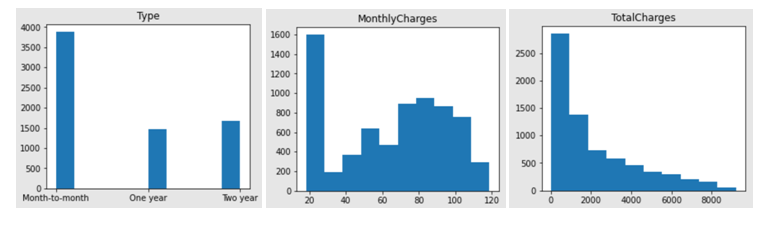
По общему анализу распределения данных можно сделать следующие выводы:\
•	Самый частый тип договоров с месячной оплатой и электронным чеком\
•	максимальное количество людей оплачивают ежемесячно суммы до 30 долларов\
•	значительное количество людей имеют большие ежемесячные платежи от 70 до 110 долларов\
•	целевой признак требует балансировки\
•	количество мужчин и женщин в выборке приблизительно равные, как и с детьми или без\
•	все дополнительные услуги пользуются популярностью 


При сравнительном анализе признаков с делением на открытые и закрытые договоры можно сделать следующие выводы, что чаще отказываются от услуг компании те клиенты, которые:\
•	заключают договор с годичной оплатой (1 раз в год или в 2 года)\
•	имеют большие ежемесячные платежи (более 80 долларов)\
•	являются клиентами от 500 до 1500 дней\
•	женатые(странная корреляция)\
•	используют интернет, подключенный по технологии оптического кабеля\
•	пользуются дополнительными услугами (OnlineBackup, StreamingTV, StreamingMovies, MultipleLines)\


Также выявлены признаки не влияющие на уход клиента (gender, SeniorCitizen, Dependents, TechSupport, phone), распределение данных признаков представлено ниже:
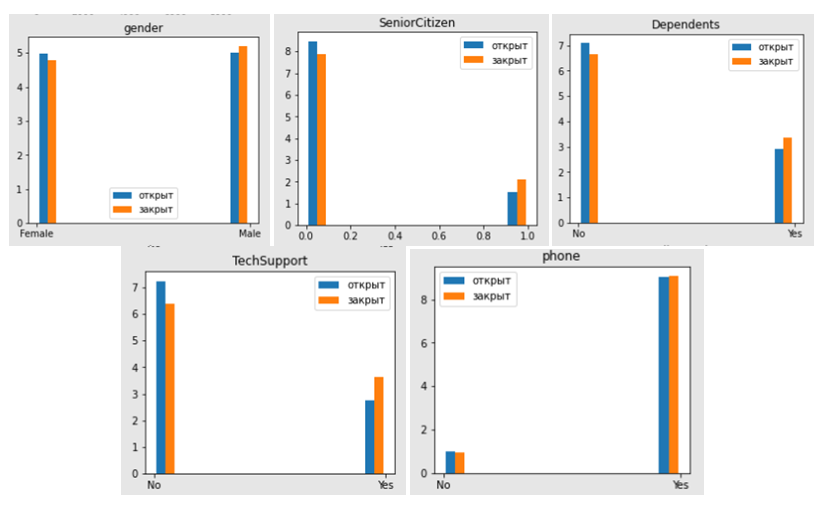

В ходе подготовки данных было выполнено следующее:\
Выделен целевой признак, разбили на тестовую и обучающую выборки (Размер обучающей выборки 5099 75.0% Размер валидационной выборки 1700 25.0%)
применили стандартизацию к числовым признакам с помощью StandardScaler
применили кодирование к категориальным признакам OneHotEncoder и OrdinalEncoder 


2.2. Подбор модели

Для обучения обучены и протестированы следующие модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier с подбором параметров с использованием GridSearchCV, полученные результаты представлены в таблице 
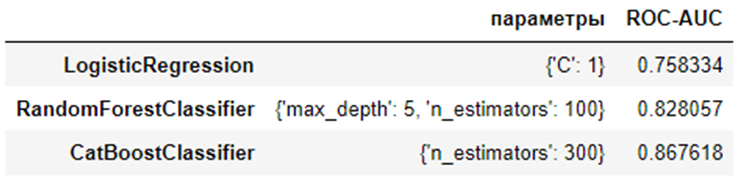
В ходе обучения моделей был произведен подбор гиперпараметров для моделей LogisticRegression, RandomForestClassifier, CatBoostClassifier и произведен расчет ROC-AUC. Лучшее значение на обучающей выборке у модели CatBoostClassifier с гиперпараметрами n_estimators': 300.

### Выводы

3.1. В ходе оценки качества полученных моделей лучшие показатели получила  Модель CatBoostClassifier (n_estimators': 300)\
Метрики качества на тестовой выборке: ROC-AUC 0.88, accuracy 0.89. Требуемая точность получена. \
3.2 При построении матрицы ошибок(Таблица ниже) было выявлено, что разработанная модель чаще будет ошибаться в предсказании, что человек планирует сменить оператора, что может уменьшить прибыль от данных клиентов, поскольку им будут предлжены более выгодные условия.\
Однако модель в более редких случаях не заметит клиента, который планирует сменить оператора, что является более весомым фактором.\
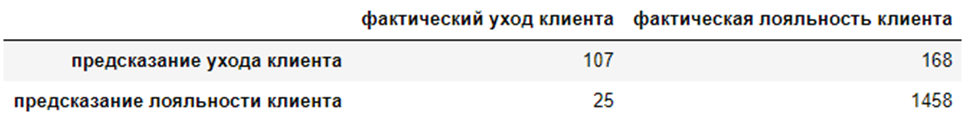
3.3 При оценке степени влияния на целевой признак было выявлено, что наиболее влияющим фактором является длительность договора, также в значительной степени влияют: тип договора, сумма оплаты в месяц, и способ оплаты. Именно от этих признаков в большей степени влияет лояльность клиента. 
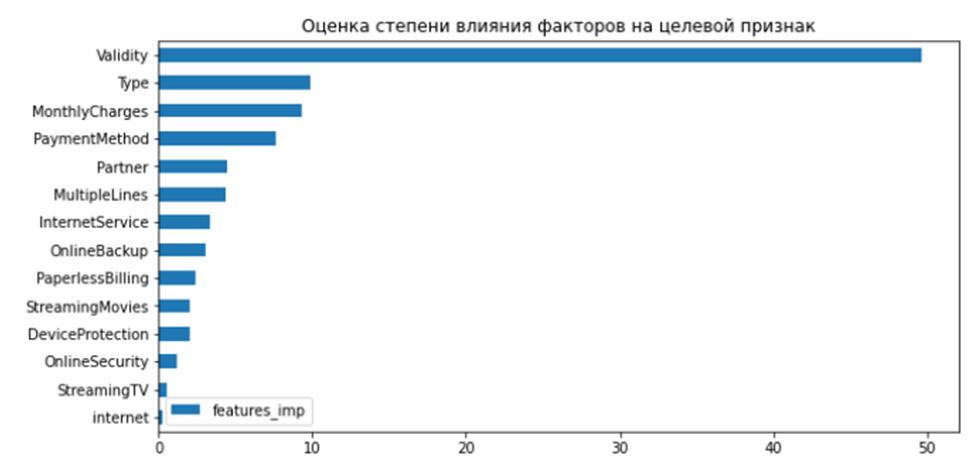

Ответы на вопросы задания: 
1. Какие пункты плана были выполнены, а какие — нет. Почему?\
Были выполнены все запланированные этапы

2. Какие трудности возникли и как вы их преодолели?\
Трудность с определением вылияющих на целевой признак факторов, с этой целью разделили датасет и сравнили распределение признаков

3. Какие ключевые шаги в решении задачи вы выделили?
- Предобработка данных. Работа с пропусками. Определение аномальных значений. Преобразование типов данных. Поиск дубликатов.
- Исследовательский анализ данных. Визуализация. Изучение срезов данных. Нахождение взаимосвязей параметров. Объединение таблиц. Вывод по данным.
- Машинное обучение. Определение гиперпараметров. Кодирование данных. Сравнение качества прогноза моделей.
- Проверка выбранной модели. Общий вывод.

4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена? \
Признаки: Type, PaperlessBilling, PaymentMethod, MonthlyCharges,  Validity, Partner,  InternetService,  OnlineSecurity,     OnlineBackup ,     DeviceProtection,  StreamingTV,       StreamingMovies ,  internet ,         MultipleLines\
Выделен целевой признак(Target), разбили на тестовую и обучающую выборки (Размер обучающей выборки 5099 75.0% Размер валидационной выборки 1700 25.0%)\
применили стандартизацию к числовым признакам с помощью StandardScaler\
применили кодирование к категориальным признакам OneHotEncoder и OrdinalEncoder 

5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?\
Модель CatBoostClassifier (n_estimators': 300)\
Метрики качества на тестовой выборке: ROC-AUC 0.88, accuracy 0.89. 